In [1]:
import tidy3d as td
import tidy3d.web as web

import autograd as ag
import autograd.numpy as np

import matplotlib.pylab as plt

In [6]:
wvl = 1.0
freq = td.C_0 / wvl
fwidth = freq/10
period = 1 / freq

beta = 0.5
velocity = td.C_0 * beta
Lx = period * velocity

ly_design = 3 * wvl
ly_channel = 0.5 * wvl
buffer = 2 * wvl

Ly = 2 * buffer + 2 * ly_design + ly_channel

eps_max = 5.0

dl = wvl / 50

# radius of the circular filter (um) and the threshold strength
radius = 0.120
threshold = 50

In [18]:
from tidy3d.plugins.autograd import rescale, make_filter_and_project

src = td.PlaneWave(
    center=(0, -Ly/2 + buffer+2 * dl, 0),
    size=(td.inf, 0, td.inf),
    direction="+",
    source_time=td.GaussianPulse(freq0=freq, fwidth=fwidth),
)

mnt_channel = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, 0, 0),
    freqs=[freq],
    name='channel',
)

mnt_viz = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, 0, 0),
    freqs=[freq],
    name='field',
)

filter_project = make_filter_and_project(radius, dl)

def get_eps(params, threshold):
    """Get the permittivity values (1, eps_wg) array as a function of the parameters (0, 1)"""
    processed_params = filter_project(params, threshold)
    eps = rescale(processed_params, 1, eps_max)
    return eps

def make_structure(params, threshold, y) -> td.Structure:
    box = td.Box(
        center=(0, y, 0),
        size=(Lx + 2 * dl, ly_channel, td.inf)
    )
    eps_data = get_eps(params, threshold).reshape((nx, ny, 1))
    custom_structure = td.Structure.from_permittivity_array(geometry=box, eps_data=eps_data)

    return custom_structure

def make_sim(params_3d, threshold, viz_mnt=False) -> td.Simulation:

    params_up, params_dn = params_3d
    
    structure_up = make_structure(params_up, threshold, y=+(ly_channel + ly_design)/2)
    structure_dn = make_structure(params_dn, threshold, y=-(ly_channel + ly_design)/2)

    monitors = [mnt_channel]
    if viz_mnt:
        monitors += [mnt_viz]
    
    return td.Simulation(
        size=(Lx, Ly, 0),
        grid_spec=td.GridSpec.uniform(dl=dl),
        boundary_spec=td.BoundarySpec.pml(x=False, y=True, z=False),
        structures=[structure_up, structure_dn],
        sources=[src],
        monitors=monitors,
        run_time=fwidth/100,
    )

In [19]:
nx = int(Lx / dl)
ny = int(ly_design / dl)

params0 = 0.5 * np.ones((2, nx, ny))

sim0 = make_sim(params0, threshold=1.0)

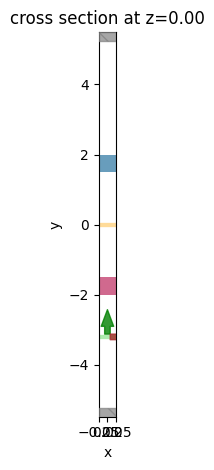

In [22]:
sim0.plot(z=0)
plt.show()

In [23]:
from tidy3d.plugins.autograd import make_erosion_dilation_penalty

penalty = make_erosion_dilation_penalty(radius, dl)